In [1]:
import pandas as pd

# Matplot & Seaborn
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report,
    accuracy_score
)
import keras
from keras.preprocessing.text import Tokenizer

from keras.models import Sequential
from keras.layers import (LSTM, 
                          Activation,
                          Conv1D,
                          MaxPooling1D,
                          Embedding, 
                          BatchNormalization,
                          Dense, 
                          TimeDistributed, 
                          Dropout, 
                          Bidirectional,
                          Flatten, 
                          GlobalMaxPool1D)
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.initializers import Constant
from tensorflow.keras import optimizers
from keras.utils.data_utils import pad_sequences

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import string
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools
import random
import datetime

import warnings 
warnings.filterwarnings('ignore')

# Set log
#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

from socket import socket
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential

# Step1 Brief description

Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

In [2]:
train_path = r'E:\Jia\Desktop\MS-DS\5511 Introduction to Deep Learning\week4\assessments\train.csv'
test_path = r'E:\Jia\Desktop\MS-DS\5511 Introduction to Deep Learning\week4\assessments\test.csv'
sample_path = r'E:\Jia\Desktop\MS-DS\5511 Introduction to Deep Learning\week4\assessments\sample_submission.csv'

In [3]:
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
sample_submission = pd.read_csv(sample_path)

In [4]:
train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [7]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      3263 non-null   int64
 1   target  3263 non-null   int64
dtypes: int64(2)
memory usage: 51.1 KB


# Step2 Exploratory data analysis
## 2.1 Data inspection

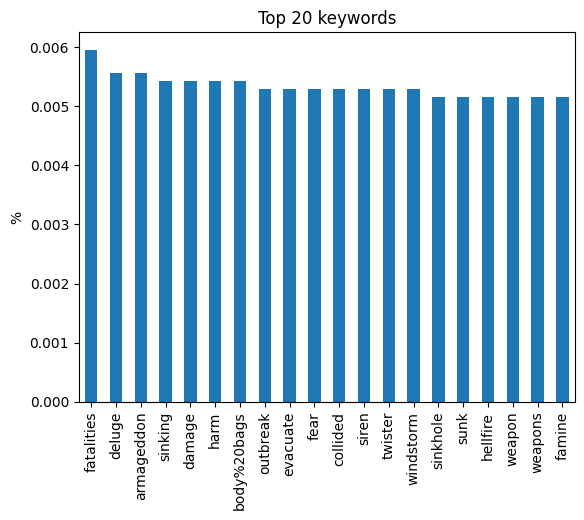

In [8]:
train['keyword'].value_counts(normalize=True)[:20].plot(kind='bar')
plt.title('Top 20 keywords')
plt.ylabel('%')
plt.show()

In [9]:
len(train[train["target"]==1]["text"].values)

3271

In [10]:
len(train[train["target"]==0]["text"].values)

4342

In [11]:
train[train["target"]==1]["text"].values[0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [12]:
train[train["target"]==0]["text"].values[0]

"What's up man?"

Text(0.5, 1.0, 'Count for zeros: 4342\nCount for ones: 3271')

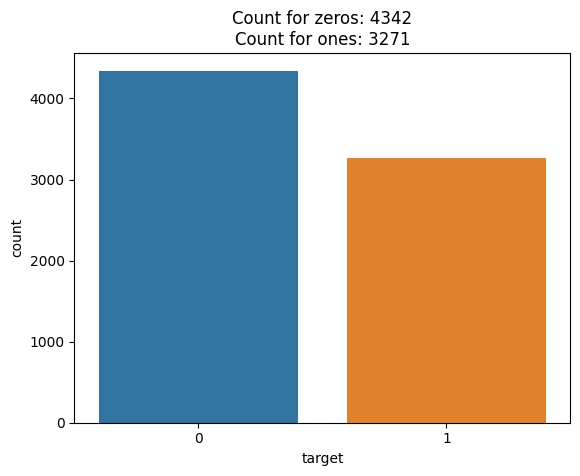

In [13]:
sns.countplot(x=train.target)
plt.title('Count for zeros: 4342' + '\n' + 'Count for ones: 3271')

We have a balanced dataset, which is good, we can use this dataset to analysis, and I noticed the dataset need to be processed before training.

## 2.2 Data pre-processing
### 1. Make text lowercase, remove text in square brackets,remove links,remove punctuation and remove words containing numbers

In [14]:
# Special thanks to https://www.kaggle.com/tanulsingh077 for this function
def clean_text(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [15]:
train['text_clean'] = train['text'].apply(clean_text)

In [16]:
train.head()

,id,keyword,location,text,target,text_clean
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders in...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...


### 2. Stopwords

In [17]:
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text

In [18]:
train['text_clean'] = train['text_clean'].apply(remove_stopwords)

In [19]:
train.head()

,id,keyword,location,text,target,text_clean
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deeds reason earthquake may allah forgive us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,residents asked shelter place notified officer...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders ca...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfires pou...


### 3. Stemming/Lematization

In [20]:
stemmer = nltk.SnowballStemmer("english")

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

In [21]:
train['text_clean'] = train['text_clean'].apply(stemm_text)

In [22]:
train.head()

,id,keyword,location,text,target,text_clean
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquak may allah forgiv us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la rong sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,resid ask shelter place notifi offic evacu she...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,peopl receiv wildfir evacu order california
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo rubi alaska smoke wildfir pour ...


### 4. Vectorization

In [23]:
x = train['text_clean']
y = train['target']

In [24]:
print(len(x),len(y))

7613 7613


In [25]:
# Split to train data and validate data
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=123)

In [26]:
print(len(x_train), len(y_train))
print(len(x_valid), len(y_valid))

6090 6090
1523 1523


In [27]:
# Instantiate the vectorizer
vectorizer = CountVectorizer()
x_train_vectors = vectorizer.fit_transform(x_train)
x_valid_vectors = vectorizer.fit_transform(x_valid)

In [28]:
# count for the first 5 tweets in the data
example_train_vectors = vectorizer.fit_transform(x_train[0:5])

In [29]:
example_train_vectors.toarray().shape

(5, 53)

In [30]:
example_train_vectors[0].toarray()

array([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 1, 0, 0, 1, 0, 0]], dtype=int64)

The above tells us that:

1. There are 53 unique words (or "tokens") in the first five tweets.
2. The first tweet contains only some of those unique tokens - all of the non-zero counts above are the tokens that DO exist in the first tweet.

### 5. TF-IDF
In information retrieval, tf–idf, TF-IDF, or TFIDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus It is often used as a weighting factor in searches of information retrieval, text mining, and user modeling. The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general. 

In [31]:
tfidf_transformer = TfidfTransformer()
x_train_tf = tfidf_transformer.fit_transform(x_train_vectors)
x_train_tfidf = x_train_tf.toarray()
x_valid_tf = tfidf_transformer.fit_transform(x_valid_vectors)
x_valid_tfidf = x_valid_tf.toarray()

In [32]:
x_train_tfidf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [33]:
x_valid_tfidf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [34]:
x_train_tfidf.shape[1]

11754

### 6. GloVe

In [35]:
max_features=3000
tokenizer=Tokenizer(num_words=max_features,split=' ')
tokenizer.fit_on_texts(train['text_clean'].values)
X = tokenizer.texts_to_sequences(train['text_clean'].values)
X = pad_sequences(X)

In [36]:
X.shape

(7613, 20)

Here size of tokenized vector is 20, it is the maximum length of clean_text considering excluding those tokens which does not belong to top 3000 tokens. That is if the maximum length of clean_text is 35, then the 15 token will not be qualified to come under top 3000 tokens.

We can restrict on enhance dimension of tokenized vector by providing a parameter maxlen to pad_sequence()

In [37]:
X[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,  467,  202,   86, 1462, 2868,   17])

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state =123)

In [39]:
X_train

array([[   0,    0,    0, ...,  723,   46,   22],
       [   0,    0,    0, ...,  106,  623,  240],
       [   0,    0,    0, ...,    3,   43,  627],
       ...,
       [   0,    0,    0, ...,  312,  109,  707],
       [   0,    0,    0, ...,  147,  228,  131],
       [   0,    0,    0, ...,  688, 2770, 2010]])

# Step3 Model architecture

An LSTM module has a cell state and three gates which provides them with the power to selectively learn, unlearn or retain information from each of the units. The cell state in LSTM helps the information to flow through the units without being altered by allowing only a few linear interactions.

In [48]:
model = Sequential()
model.add(Embedding(input_dim = 7613, output_dim = 64, name='Embedding'))
model.add(tf.keras.layers.LSTM(128, return_sequences=True))
model.add(tf.keras.layers.LSTM(128))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1))
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(0.0002), metrics=["accuracy"])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding (Embedding)       (None, None, 64)          487232    
                                                                 
 lstm_16 (LSTM)              (None, None, 128)         98816     
                                                                 
 lstm_17 (LSTM)              (None, 128)               131584    
                                                                 
 dense_24 (Dense)            (None, 128)               16512     
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_25 (Dense)            (None, 32)                4128      
                                                                 
 dense_26 (Dense)            (None, 1)                

In [49]:
history = model.fit(X_train, y_train, epochs = 15, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/15
96/96 [==============================] - 7s 22ms/step - loss: 0.6789 - accuracy: 0.5686 - val_loss: 0.6506 - val_accuracy: 0.5772
Epoch 2/15
96/96 [==============================] - 1s 13ms/step - loss: 0.5686 - accuracy: 0.6795 - val_loss: 0.4736 - val_accuracy: 0.7748
Epoch 3/15
96/96 [==============================] - 1s 13ms/step - loss: 0.3957 - accuracy: 0.8245 - val_loss: 0.4561 - val_accuracy: 0.8030
Epoch 4/15
96/96 [==============================] - 1s 13ms/step - loss: 0.3462 - accuracy: 0.8511 - val_loss: 0.4748 - val_accuracy: 0.8056
Epoch 5/15
96/96 [==============================] - 1s 13ms/step - loss: 0.3116 - accuracy: 0.8713 - val_loss: 0.4848 - val_accuracy: 0.7991
Epoch 6/15
96/96 [==============================] - 1s 13ms/step - loss: 0.2864 - accuracy: 0.8842 - val_loss: 0.5175 - val_accuracy: 0.7991
Epoch 7/15
96/96 [==============================] - 1s 13ms/step - loss: 0.2637 - accuracy: 0.8966 - val_loss: 0.5417 - val_accuracy: 0.7925
Epoch 8/15
96

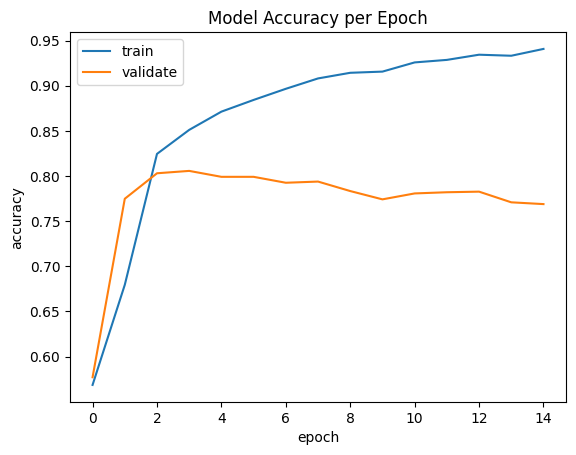

In [50]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy per Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch') 
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

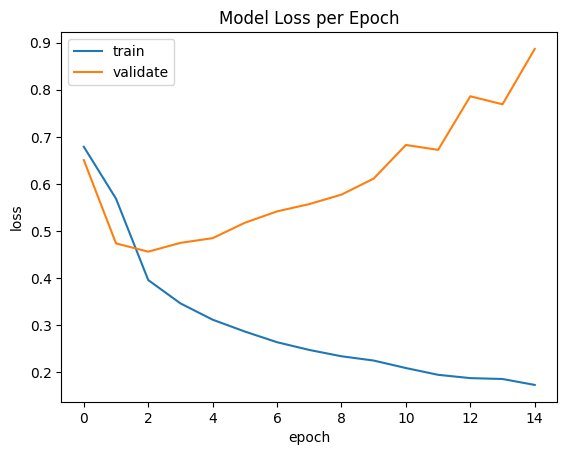

In [51]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss per Epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

48/48 [==============================] - 1s 4ms/step


<AxesSubplot: >

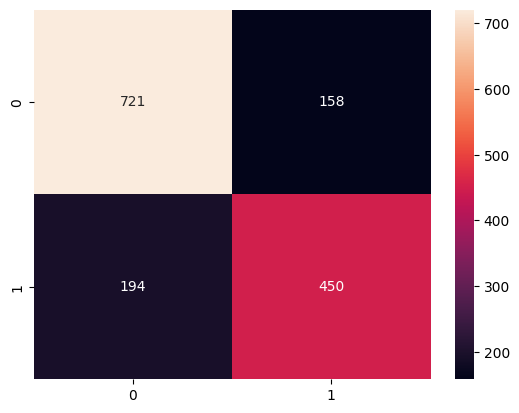

In [52]:
from sklearn import metrics
y_preds = (model.predict(X_test) > 0.5).astype("int32")
conf = metrics.confusion_matrix(y_test, y_preds)
sns.heatmap(conf, annot=True, fmt='d')

In [53]:
metrics.roc_auc_score(y_test, y_preds)

0.7595040241946311

 # Step4 Results and analysis

According to information in training and testing data, there are some non-value data in columns keyword and location, which do not impact our results in this study, so we just leave them in the dataset. 

In training data,  there are 3271 tweets labeled 1 which means a given tweet is about a real disaster, and the rest of 4342 tweets are labeled 0 which means a given tweet is not about a real disaster. We have a balanced dataset, which is good, we can use this data to further  study, and I noticed the text includes punctuation and links and square brackets, etc, I need to pre processing them before training data for the ML model.I make text lowercase, remove text in square brackets, remove links, remove punctuation and remove words containing numbers, and deal with stopwords and stemming. then I need to convert each of those messages into a vector the SciKit Learn's algorithm models can work with.

Tokenizer() uses fit_on_texts() and texts_to_sequences() to encode the texts to numerical values.
Fit_on_texts() Updates internal vocabulary based on a list of texts. It will create a dictionary with word mapping with an index (unique numerical value). Here all the words will be in lower case and the least value of index will be the more frequent word.
texts_to_sequences() Transforms each text in texts to a sequence of numerical values. It will assign the index of each to the word. So the output will be a series of numerical values. We are not having the same length for all the sentences and while providing input to neural networks, we should have the same dimension for all inputs. So pad_sequence() is used to pad the input so that all the inputs have the same dimension. It will add zeros to the input, in the beginning, to make sure all the inputs have the same dimension.

LSTM has 3 gates:(1) Forget Gate: - It decides which information from the previous timestamp is irrelevant and can be forgotten. It has the first neural network layer with sigmoid function.
(2) Input Gate: Try to learn new information from the input to the cell. It has 2 neural layers, first one with sigmoid activation function and second one with tanh function. First, a sigmoid layer called the “input gate layer” decides which values to update. Next, the tanh layer creates a vector of new candidate values.
(3) Output Gate: It passes the information from the current timestamp to the next. It has a sigmoid activation function.

I created a LSTM model which includes activation function of dense layer, dropout, loss function and optimizer,Adam is used as an optimizer which is a replacement optimization algorithm for stochastic gradient descent for training deep learning models. Default learning rate of Adam is 0.001, but here I have initialized it to 0.0002. I set epochs equal to 15, based on the plot and graph we can see the accuracy of the model is increasing. Especially after epoch 3, it reached above 82%, and the accuracy of these models still appears to be improving after 15 epochs. I study the confusion matrix and calculate the area under the receiver operating characteristic curve (ROC AUC) from prediction scores which is approximately 0.76.

# Step5 Conclusion

There are many methods to process texts to matrix form, including TF-IDF, GloVe, Word2Vec, etc. I tried TF-IDF first, but the running time was too long when I applied the processed dataset from TF-IDF, even in a GPU environment, so I tried another method which is GloVe. 

To build my sequential neural network model, I used the LSTM model to analyze the dataset, but I notice the accuracy of model appears to increase after 15 epochs, I am going to try more epochs in the further study and experiment different learning rate for Adam function.